<img style="float: right;" src="unifor.jpg" width="250px">
<font size="5" face="Arial">
    <b>Universidade de Fortaleza</b>
</font><br>
<font size="3" face="Arial">
    <b>Programa de Pós-Graduação em Informática Aplicada - PPGIA <br>
Disciplina: Análise de Dados em Grafos <br>
Prof.: Raimir Filho <br>
Equipe: Daniel, Eduardo, Ricardo e Vitor<br>
    </b>
</font>

## Colaboração de Professores do PPGIA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import networkx as nx
from networkx.algorithms import bipartite

from fuzzywuzzy import fuzz, process

### Carregar o Grafo a partir do arquivo CSV.

In [2]:
df = pd.read_csv('datasets/ppgia_coautoria-bipartite.csv', delimiter=';')
df

,ANO,TITULO,AUTORES
0,1989,O Círculo Dos Nove Pontos,Plácido Rogerio Pinheiro
1,1990,Um Estudo Sobre As Perdas Em Barras De Ferro A...,Plácido Rogerio Pinheiro
2,1990,Um Estudo Sobre As Perdas Em Barras De Ferro A...,Humberto Jansen
3,1991,Técnicas Alternativas Para Resolução De Um Pro...,Plácido Rogerio Pinheiro
4,1991,Técnicas Alternativas Para Resolução De Um Pro...,Adriana Carlos Paz
...,...,...,...
2362,2021,Multi-Task Learning With Multi-View Weighted F...,Xiaoqing Wang
2363,2021,Multi-Task Learning With Multi-View Weighted F...,Yanping Zhang
2364,2021,Multi-Task Learning With Multi-View Weighted F...,Heye Zhang
2365,2021,Multi-Task Learning With Multi-View Weighted F...,Javier Del Ser


### Limpeza / padronização dos nome dos autores

#### Definição das funções de tratamento dos nome dos autores

In [3]:
def preparaListaTopMaisAutores(qtdeOcorrenciaCorte: int):
    df_aux = df[(df['AUTORES'].map(df['AUTORES'].value_counts()) > qtdeOcorrenciaCorte) & (df['PROCESSADO'] == 'N')]
    df_aux = df_aux.sort_values(by='AUTORES')
    top_autores = df_aux['AUTORES'].unique().tolist()
    if len(top_autores) >= 15:
        top_autores = top_autores[0:15]
    print('\n*** Top {} autores com mais de {} ocorrências:\n\n{} '.format(len(top_autores), qtdeOcorrenciaCorte, top_autores))
    return top_autores

# def preparaListaTopAutores(qtdeAutor: int):
#     df_aux = df[(df['AUTORES'].map(df['AUTORES'].value_counts()) > 0) & (df['PROCESSADO'] == 'N')]
#     df_aux = df_aux.head(qtdeAutor + 1)
#     top_autores = df_aux['AUTORES'].unique().tolist()
#     print('\n*** Top {} autores: \n\n{}'.format(qtdeAutor, top_autores))
#     return top_autores

def preparaListaTopNAutores(qtdeAutor: int):
    df_aux = df[df['PROCESSADO'] == 'N']
    df_aux = df_aux['AUTORES'].value_counts()
    top_autores = df_aux.index[0:qtdeAutor].tolist()
    #print('\n*** Top {} autores: \n\n{}'.format(qtdeAutor, top_autores))
    return top_autores

def atualizaListaCompletaAutores():
    #df_aux = df[df['PROCESSADO'] == 'N']
    df_aux = df
    autores = df_aux['AUTORES'].unique().tolist()
    #print('\n*** Quantidade de nomes diferentes não processados: ', len(autores))
    return autores

def verificaSimilaridadeAutores(top_autores, autores, corte):
    print('\n*** Taxa de Similaridade:')
    for autor in autores:
        if process.extractOne(autor, top_autores, score_cutoff=corte, scorer=fuzz.token_set_ratio) is not None:
            print(autor, process.extractOne(autor, top_autores, score_cutoff=corte, scorer=fuzz.token_set_ratio))

def corrigeNomeAutor(top_autores, corte):
    for autor in top_autores:
        for item in df.AUTORES.items():
            if fuzz.token_set_ratio(autor, item[1]) > corte:
                df.loc[df['AUTORES'] == item[1], ['AUTORES']] = autor
                df.loc[df['AUTORES'] == item[1], ['PROCESSADO']] = 'S'
                
def corrigeNomeAutorDif(top_autores, corte):
    for autor in top_autores:
        for item in df.AUTORES.items():
            if autor != item[1]:
                if fuzz.token_set_ratio(autor, item[1]) > corte:
                    df.loc[df['AUTORES'] == item[1], ['AUTORES']] = autor
                    df.loc[df['AUTORES'] == item[1], ['PROCESSADO']] = 'S'
            else:
                df.loc[df['AUTORES'] == item[1], ['PROCESSADO']] = 'S'

#### Comparando um nome de autor com os demais (CORTE >= 95)

In [4]:
# Retira aspas duplas e simples do texto
df['AUTORES'] = df['AUTORES'].str.replace(r'\'', '')
df['AUTORES'] = df['AUTORES'].str.replace(r'\"', '')

print('*** Quantidade de ocorrências por autor: ')
df['AUTORES'].value_counts()

*** Quantidade de ocorrências por autor: 


Victor Hugo Costa De Albuquerque    158
Plácido Rogerio Pinheiro            126
Maria Elizabeth Sucupira Furtado     40
Maria Andréia Formico Rodrigues      38
Adriano Bessa Albuquerque            38
                                   ... 
Paulo Cesar Cortez                    1
Mateus Roder                          1
Fernando Lincoln Matos                1
Alan M Braga                          1
Ana Candida Natali                    1
Name: AUTORES, Length: 982, dtype: int64

In [5]:
df = df.sort_values(by='AUTORES')
df['PROCESSADO'] = 'N'
print('*** Quantidade de nomes diferentes (inicio): ', len(df['AUTORES'].unique().tolist()))

*** Quantidade de nomes diferentes (inicio):  982


In [6]:
valor_corte = 95
qtde_ocorrencia = 1
qtde_nao_processado = len(df[df['PROCESSADO'] == 'N'])

while qtde_nao_processado > 0:
    lista_top_autores = preparaListaTopNAutores(qtde_ocorrencia)
    lista_autores = atualizaListaCompletaAutores()
    #verificaSimilaridadeAutores(lista_top_autores, lista_autores, valor_corte)
    corrigeNomeAutor(lista_top_autores, valor_corte)
    qtde_nao_processado = len(df[df['PROCESSADO'] == 'N'])

In [7]:
print('*** Resumo dos quantidade de autores processados: \n')
print(df['PROCESSADO'].value_counts())


*** Resumo dos quantidade de autores processados: 

S    2367
Name: PROCESSADO, dtype: int64


In [8]:
print('*** Quantidade de ocorrências por autor: ')
df['AUTORES'].value_counts()


*** Quantidade de ocorrências por autor: 


Victor Hugo Costa De Albuquerque    174
Plácido Rogerio Pinheiro            148
Joao Jose Vasco Peixoto Furtado      52
Maria Elizabeth Sucupira Furtado     51
Joel J P C Rodrigues                 46
                                   ... 
Sarah Mesquita Lima                   1
R Cavaliere                           1
Antônio Roberto Lins De Macedo        1
Odésia Fernanda Gomes De Assis        1
Thiago Ivo De S Menezes               1
Name: AUTORES, Length: 871, dtype: int64

In [9]:
print('*** Quantidade de nomes diferentes: ', len(df['AUTORES'].unique().tolist()))


*** Quantidade de nomes diferentes:  871


#### Refazendo a busca por nomes comparando o um autor com os demais (CORTE >= 95)

In [10]:
df['PROCESSADO'] = 'N'
df = df.sort_values(by='AUTORES')
valor_corte = 90
qtde_ocorrencia = 1
qtde_nao_processado = len(df[df['PROCESSADO'] == 'N'])

while qtde_nao_processado > 0:
    lista_top_autores = preparaListaTopNAutores(qtde_ocorrencia)
    lista_autores = atualizaListaCompletaAutores()
    #verificaSimilaridadeAutores(lista_top_autores, lista_autores, valor_corte)
    corrigeNomeAutor(lista_top_autores, valor_corte)
    qtde_nao_processado = len(df[df['PROCESSADO'] == 'N'])

In [11]:
print('*** Quantidade de ocorrências por autor: ')
df['AUTORES'].value_counts()


*** Quantidade de ocorrências por autor: 


Victor Hugo Costa De Albuquerque    174
Plácido Rogerio Pinheiro            153
Maria Elizabeth Sucupira Furtado     52
Joao Jose Vasco Peixoto Furtado      52
Joel J P C Rodrigues                 47
                                   ... 
A C Pascalicchio                      1
Paulo Bruno De A Braga                1
Artur Veloso                          1
Weskleidourado Teófilo                1
Adauto R De Carvalho                  1
Name: AUTORES, Length: 827, dtype: int64

In [12]:
print('*** Quantidade de nomes diferentes: ', len(df['AUTORES'].unique().tolist()))


*** Quantidade de nomes diferentes:  827


#### Realizando a busca de autores diferentes do corrente (CORTE >= 90)

In [13]:
df['PROCESSADO'] = 'N'
df = df.sort_values(by='AUTORES')
valor_corte = 90
qtde_ocorrencia = 1
qtde_nao_processado = len(df[df['PROCESSADO'] == 'N'])

while qtde_nao_processado > 0:
    lista_top_autores = preparaListaTopNAutores(qtde_ocorrencia)
    lista_autores = atualizaListaCompletaAutores()
    #verificaSimilaridadeAutores(lista_top_autores, lista_autores, valor_corte)
    corrigeNomeAutorDif(lista_top_autores, valor_corte)
    qtde_nao_processado = len(df[df['PROCESSADO'] == 'N'])

In [14]:
print('*** Quantidade de ocorrências por autor: ')
df['AUTORES'].value_counts()


*** Quantidade de ocorrências por autor: 


Victor Hugo Costa De Albuquerque    174
Plácido Rogerio Pinheiro            153
Joao Jose Vasco Peixoto Furtado      52
Maria Elizabeth Sucupira Furtado     52
Joel J P C Rodrigues                 47
                                   ... 
A C Pascalicchio                      1
Paulo Bruno De A Braga                1
Artur Veloso                          1
Weskleidourado Teófilo                1
Gudelia Baluarte Morales              1
Name: AUTORES, Length: 827, dtype: int64

In [15]:
print('*** Quantidade de nomes diferentes: ', len(df['AUTORES'].unique().tolist()))


*** Quantidade de nomes diferentes:  827


### Criação do Grafo dos trabalhos publicados

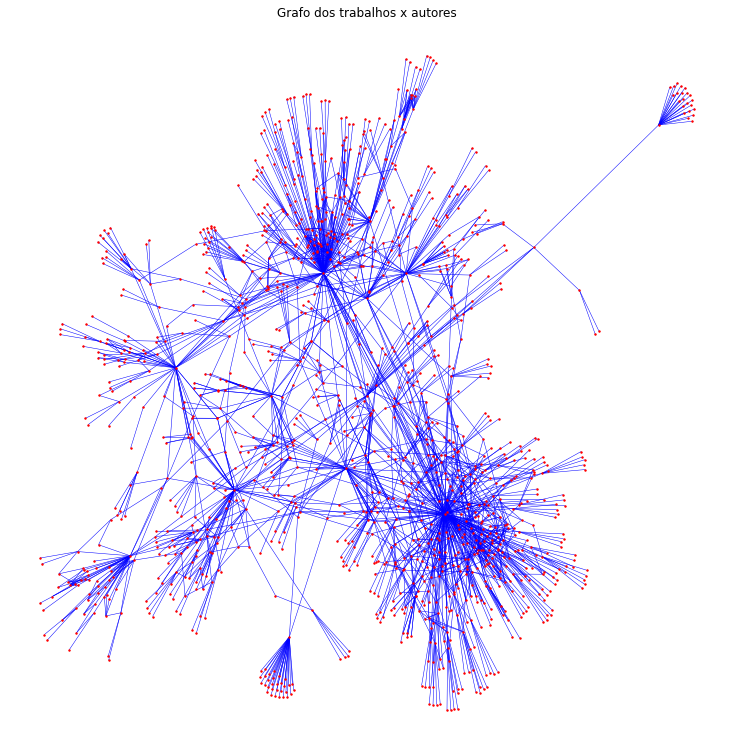

In [16]:
G = nx.from_pandas_edgelist(df, 'TITULO', 'AUTORES')

plt.figure(figsize=(10, 10))
nx.draw(G, pos=nx.spring_layout(G), with_labels=False, node_color='red', node_size=2, edge_color='blue', width=0.5)
plt.title('Grafo dos trabalhos x autores')
plt.show()

### Representar os dados como um Grafo Bipartido entre os trabalhos publicados e os autores

In [17]:
if nx.bipartite.is_bipartite(G):
    print('O Grafo é Bipartido.')

O Grafo é Bipartido.


In [18]:
B = nx.Graph()

B.add_nodes_from(df['TITULO'], bipartite=0, node_color='b')
B.add_nodes_from(df['AUTORES'], bipartite=1, node_color='r')

for _, row in df.iterrows():
    B.add_edge(row['TITULO'], row['AUTORES'])

titulos, autores = bipartite.sets(B)
print('Quantidade Total de Títulos: ', len(titulos))
print('Quantidade Total de Autores: ', len(autores))

#https://github.com/valiantljk/graph-partition/tree/master/algorithms/bipartite

Quantidade Total de Títulos:  478
Quantidade Total de Autores:  827


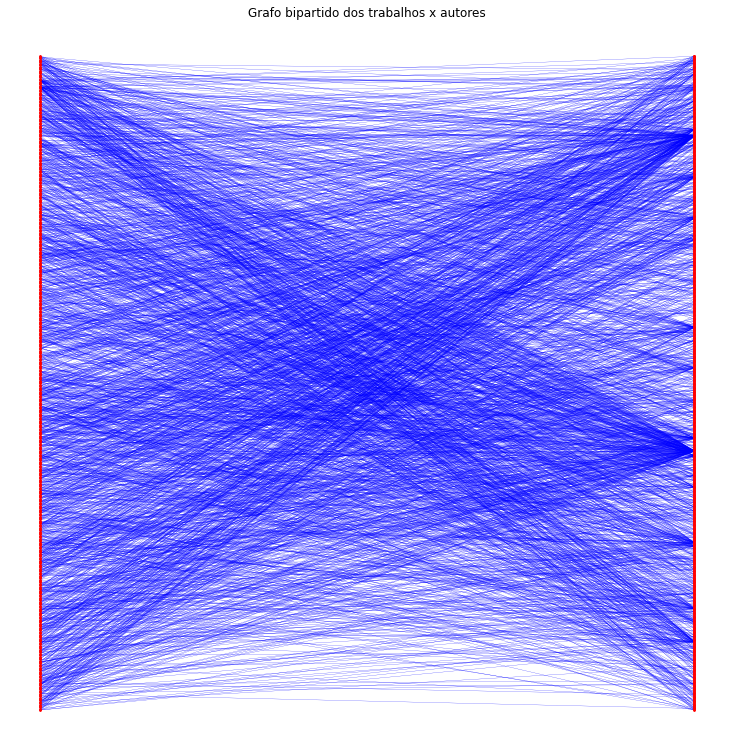

In [19]:
plt.figure(figsize=(10, 10))

# pos = dict()
# pos.update((n, (0, i*10)) for i, n in enumerate(titulos))
# pos.update((n, (0.5, i*10)) for i, n in enumerate(autores))
# num_edges = B.number_of_edges()
# num_nodes = B.number_of_nodes()
#nx.draw(B, pos=pos, edge_color=np.random.random(num_edges), edge_cmap=plt.get_cmap("Blues"), node_color=np.random.random(num_nodes), cmap=plt.get_cmap("Reds"))

top = nx.bipartite.sets(B)[0]
nx.draw(B, pos=nx.bipartite_layout(B, top), node_color='red', node_size=3, edge_color='blue', width=0.2)
plt.title('Grafo bipartido dos trabalhos x autores')
plt.show()

### Calcular as seguintes propriedades da rede:
#### - Densidade, quantidade de nós isolados, diâmetro, distância média entre os nós, coeficiente de clustering.

In [20]:
#Exibindo a densidade
print('*** Densidade:', round(nx.bipartite.density(B, top), 2))

#Exibindo o Espectro do Grafo Bipartido
print('\n*** Espectro:', nx.bipartite.spectral_bipartivity(B))

#Exibindo os vertices isolados
print('\n*** Vertices Isolados:', list(nx.isolates(B)))

#Exibindo o Diametro
print('\n*** Diametro:', nx.diameter(B))

#Exibindo o Coeficiente de Clustering
print('\n*** Coeficiente de Clustering:', nx.average_clustering(B))

#Exibindo a Distância entre nós
print('\n*** Distância Média entre nós:\n', nx.k_nearest_neighbors(B))


*** Densidade: 0.01

*** Espectro: 1.0

*** Vertices Isolados: []

*** Diametro: 12

*** Coeficiente de Clustering: 0.0

*** Distância Média entre nós:
 {8: 18.386363636363637, 6: 25.22705314009662, 5: 26.522772277227723, 23: 3.0869565217391304, 3: 22.65461847389558, 4: 25.88063063063063, 7: 22.81142857142857, 9: 16.42222222222222, 2: 14.065445026178011, 10: 7.18, 33: 2.5606060606060606, 13: 3.3076923076923075, 1: 8.856363636363636, 28: 4.392857142857143, 12: 5.027777777777778, 11: 5.03030303030303, 20: 4.175, 30: 5.166666666666667, 42: 4.238095238095238, 43: 5.674418604651163, 26: 5.038461538461538, 19: 4.7631578947368425, 36: 3.3333333333333335, 40: 3.6, 39: 5.615384615384615, 123: 3.813008130081301, 166: 5.753012048192771}


### Identificar os autores com maior quantidade de artigos compartilhados.

In [21]:
top_collaboration = sorted(B.degree, key=lambda x: x[1], reverse=True)

top_collaboration[:10]

[('Victor Hugo Costa De Albuquerque', 166),
 ('Plácido Rogerio Pinheiro', 123),
 ('Joel J P C Rodrigues', 43),
 ('Joao Jose Vasco Peixoto Furtado', 42),
 ('Maria Elizabeth Sucupira Furtado', 40),
 ('Pedro P Rebouças Filho', 39),
 ('Maria Andréia Formico Rodrigues', 36),
 ('The Crosscutting Impact Of The Aosd Brazilian Research Community', 33),
 ('André Luís Vasconcelos Coelho', 33),
 ('J M R S Tavares', 30)]

### Gerar um Grafo Monopartido ponderado com apenas os autores.

In [22]:
#M = bipartite.projected_graph(B, nodes=autores, multigraph=False)
#M = bipartite.overlap_weighted_projected_graph(B, nodes=autores, jaccard=False)
#M = bipartite.collaboration_weighted_projected_graph(B, nodes=autores)

#O gráfico projetado ponderado é a projeção da rede bipartida B nos nós especificados com pesos representando o número de vizinhos compartilhados
M = bipartite.weighted_projected_graph(B, autores, ratio=False)
#list(M.edges(data=True))

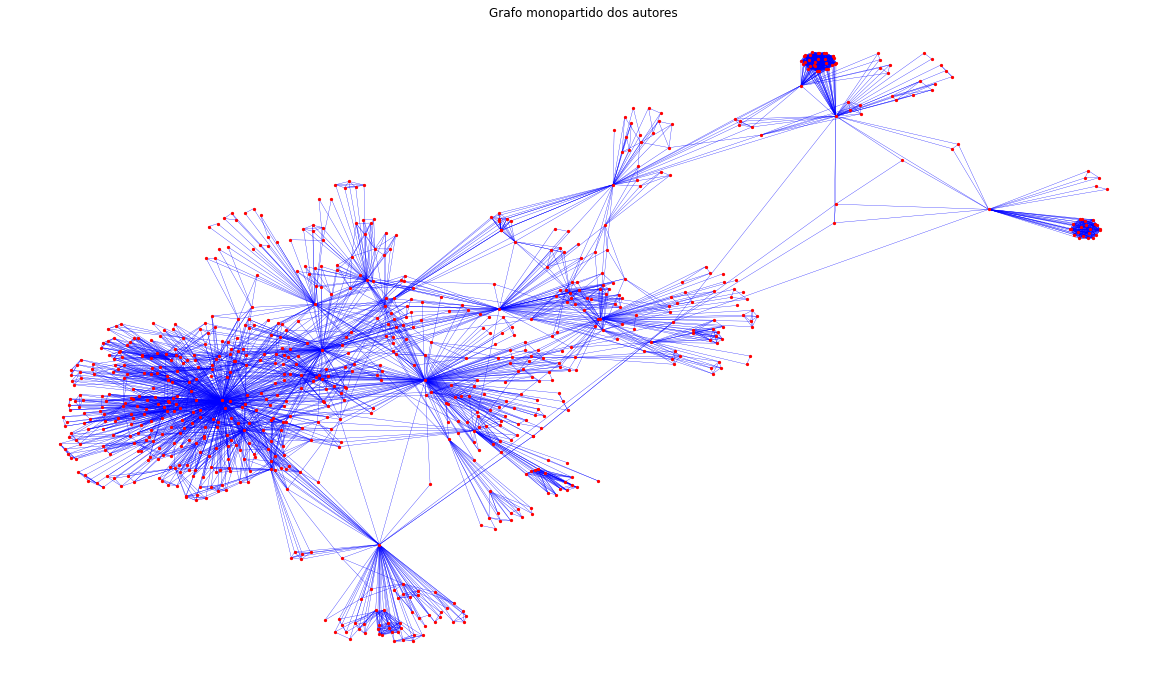

In [23]:
plt.figure(figsize=(16, 9))
nx.draw(M, pos=nx.spring_layout(M), node_color='red', node_size=5, edge_color='blue', width=0.3)
plt.title('Grafo monopartido dos autores')
plt.show()

### Identificar os autores com maior colaboração com outros autores

In [24]:
n = 5

top_collaboration = sorted(M.degree, key=lambda x: x[1], reverse=True)
top_collaboration[:n]


[('Victor Hugo Costa De Albuquerque', 351),
 ('Plácido Rogerio Pinheiro', 154),
 ('Joel J P C Rodrigues', 116),
 ('Pedro P Rebouças Filho', 92),
 ('Joao Jose Vasco Peixoto Furtado', 75)]

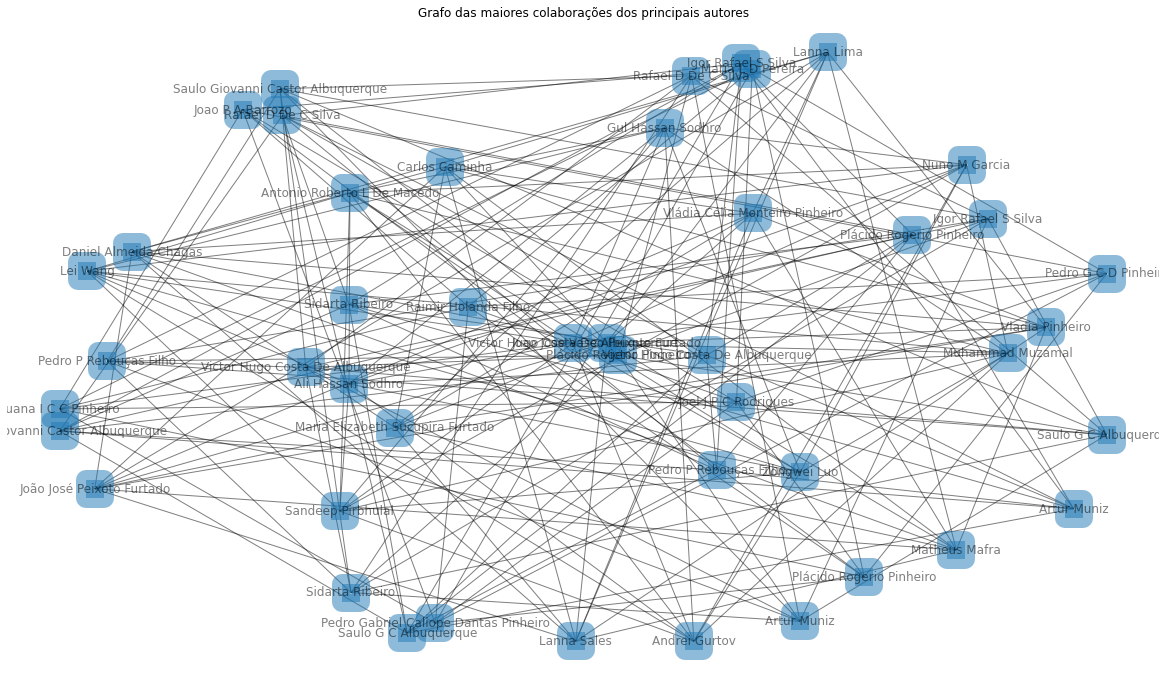

In [25]:
plt.figure(figsize=(16, 9))
for autor in top_collaboration[:n]:
    top_autores_cliques = []
    top_clique_autor = max(nx.cliques_containing_node(M, nodes=autor[0]), key=len)
    for a in top_clique_autor:
        top_autores_cliques.append(a)
        
    G1 = nx.subgraph(M, top_autores_cliques)
    nx.draw(G1, node_shape='s', with_labels=True, alpha=0.5, linewidths=20)

plt.title('Grafo das maiores colaborações dos principais autores')
plt.show()

### Gerar um gráfico com a Frequência x Valor Link

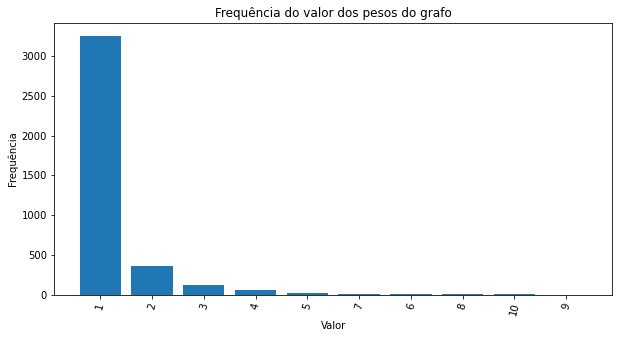

In [26]:
links = nx.get_edge_attributes(M, 'weight')

frequencia = {}
for v in links.values():
    if(not(v in frequencia)):
        frequencia[v] = 0
    frequencia[v] += 1

df_frequencia = pd.DataFrame({'Valor': list(frequencia.keys()),
                              'Frequência': list(frequencia.values())})
df_frequencia = df_frequencia.nlargest(columns='Frequência', n=10)
    
plt.figure(figsize=(10, 5))
y_pos = np.arange(10)
plt.bar(y_pos, df_frequencia['Frequência'])
plt.title('Frequência do valor dos pesos do grafo')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.xticks(y_pos, df_frequencia['Valor'], rotation=75)    
plt.show()

### Aplicar diferentes cortes e analisar

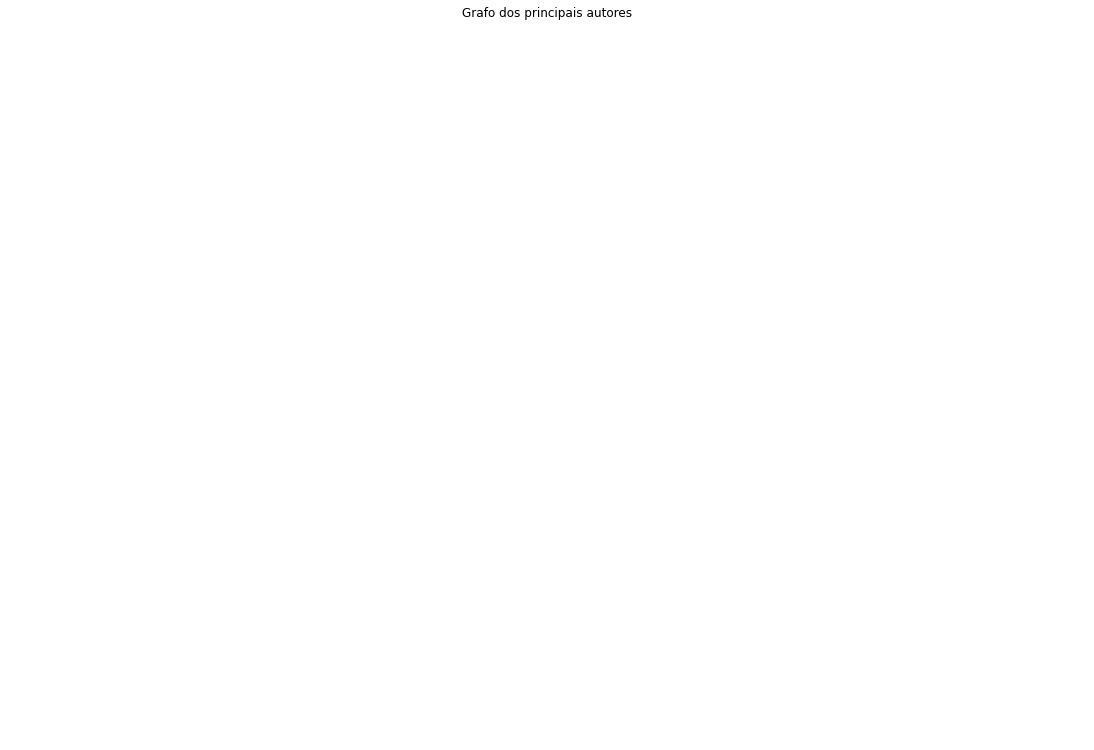

In [28]:
#Apresentar o grafo dos nós com mais de 38 colaborações
remove = [node for node, degree in dict(M.degree()).items() if degree < 38]
M.remove_nodes_from(remove)

plt.figure(figsize=(15, 10))
labels = nx.get_edge_attributes(M,'weight')
nx.draw(M, pos=nx.spring_layout(M), node_color='red', node_size=10, edge_color='blue', width=1, with_labels=True, edge_labels=labels)
plt.title('Grafo dos principais autores')
plt.show()
